<a href="https://colab.research.google.com/github/nrc2/Reconhecimento_de_Voz_DEEPFAKE/blob/main/Reconhecimento_de_Voz_Sinais_e_Sistemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTAÇÕES**

In [ ]:
import librosa as librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import zipfile
import random

# **DOCUMENTAÇÕES E LINKS ÚTEIS**

https://librosa.org/doc/latest/

Base de Dados:
https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition

## **IDEIAS DE FEATURES PARA COLETAR**
https://librosa.org/doc/latest/generated/librosa.stft.html#librosa.stft
https://librosa.org/doc/latest/generated/librosa.feature.chroma_stft.html#librosa.feature.chroma_stft
https://librosa.org/doc/latest/generated/librosa.feature.rms.html#librosa.feature.rms
https://librosa.org/doc/latest/generated/librosa.feature.spectral_centroid.html#librosa.feature.spectral_centroid
https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html#librosa.feature.mfcc

# **INSTRUÇÕES**

Para executar, esse colab precisa acessar arquivos específicos, a forma ideal é liberar o acesso ao seu google Drive e seguir as instruções a seguir.

É necessário baixar os arquivos dos audios no seu Drive, para isso, as instruções estão indicadas na sessão **IMPORTAR DADOS** abaixo
* A pasta que contém o arquivos dos audios precisam estar no seu drive, dentro de uma pasta chamada Sinais e Sistemas
* O código foi projetado para operar sobre uma pasta AUDIO que contenha as pastas FAKE e REAL com os audios correspondentea

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **IMPORTAR DADOS**

Se for a sua primeira vez executando esse colab, baixe esse arquivo zip e o salve na pasta raíz do seu drive:
https://drive.google.com/file/d/1hWNaVp7SS_sxpo2ZvNRBFgNkBkvTBp7w/view?usp=drive_link

Execute as duas células abaixo, elas irão descompactar o arquivo zip que contém os audios a serem manipulados no seu drive

In [ ]:
def unzip(path, destiny):
  with zipfile.ZipFile(path, 'r') as zip_ref:
      zip_ref.extractall(destiny)

In [ ]:
# unzip("/content/drive/MyDrive/archive.zip", "/content/drive/MyDrive/Sinais e Sistemas/")

# **CARREGAR DADOS**

Com os arquivos descompactados na pasta Sinais e Sistemas do seu drive, pode dar prosseguimento na importação dos dados para o Colab que está executando

Vamos agora identificar os diretórios dos arquivos de áudio, listar os arquivos de áudio e criar uma lista de arquivos e categorias:

In [ ]:
# Diretórios dos áudios
real_audio_dir = "/content/drive/MyDrive/Sinais e Sistemas/KAGGLE/AUDIO/REAL"
fake_audio_dir = "/content/drive/MyDrive/Sinais e Sistemas/KAGGLE/AUDIO/FAKE"

real_csv_dir = "/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL"
fake_csv_dir = "/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE"

# Função para listar os arquivos em um diretório
def listar_arquivos(diretorio):
    return [os.path.join(diretorio, arquivo) for arquivo in os.listdir(diretorio)]

# Listar arquivos e criar lista de arquivos e categorias
arquivos_reais = listar_arquivos(real_audio_dir)
arquivos_fakes = listar_arquivos(fake_audio_dir)

csv_reais = listar_arquivos(real_csv_dir)
csv_fakes = listar_arquivos(fake_csv_dir)

# Criar uma lista de tuplas (caminho do arquivo, categoria)
dados_audio = [(arquivo, 'real') for arquivo in arquivos_reais] + [(arquivo, 'fake') for arquivo in arquivos_fakes]

# **POR QUE NÃO REALIZAR O PRÉ-PROCESSAMENTO DE DADOS?**

Este projeto de Reconhecimento de Sons, focado na distinção entre vozes reais e deepfakes, adota uma abordagem específica para a coleta e preparação dos dados de áudio. A escolha deliberada de não realizar um pré-processamento extensivo nos áudios é baseada nas características intrínsecas da base de dados "DEEP-VOICE: DeepFake Voice Recognition". A seguir, apresentamos as principais razões para essa decisão:

1. **Variação Realista:**
   - A base de dados inclui áudios de oito indivíduos distintos, abrangendo uma variedade de contextos, como discursos de vitória, discursos de premiações e monólogos de despedida. A presença de diferentes condições acústicas, níveis de qualidade e durações de áudio contribui para uma representação realista e diversificada.

2. **Preservação de Ambiente e Estilo:**
   - O processo de geração de deepfakes envolve uma etapa chamada Retrieval-based Voice Conversion (RVC). Durante essa etapa, a voz original é convertida para outra individualidade sem alterar o ambiente de fundo. A separação prévia dos vocais e dos acompanhamentos garante que o estilo da voz deepfake não seja convertido junto com possíveis ruídos de fundo, como aplausos ou risadas. Essa abordagem visa preservar sons ambientais enquanto converte apenas a voz do falante.

3. **Respeito à Integridade dos Dados:**
   - Manter os áudios em seu estado original, sem pré-processamento extensivo, preserva a integridade dos dados fornecidos na base de dados. Isso reflete a decisão consciente de respeitar as características únicas de cada áudio e evitar modificações que possam influenciar negativamente na representação fidedigna dos sinais de áudio.

Essa estratégia visa garantir que o modelo de reconhecimento de sons seja treinado e avaliado em condições semelhantes às encontradas na base de dados original, proporcionando uma abordagem autêntica para a tarefa em questão.

# **ANÁLISE E TRATAMENTO DE DADOS**

Explorar visualmente os dados é uma etapa valiosa para entender melhor as características e padrões presentes nos áudios.
Vamos primeiro visualiza as formas de onda de alguns desses dados:

In [ ]:
def showAudio(audio_path):
  plt.figure(figsize=(15, 5))
  waveform, sr = librosa.load(audio_path, sr=None)
  librosa.display.waveshow(waveform, sr=sr)

  plt.title('Forma de Onda - Áudio Real')
  plt.xlabel('Tempo (s)')
  plt.ylabel('Amplitude')
  plt.show()

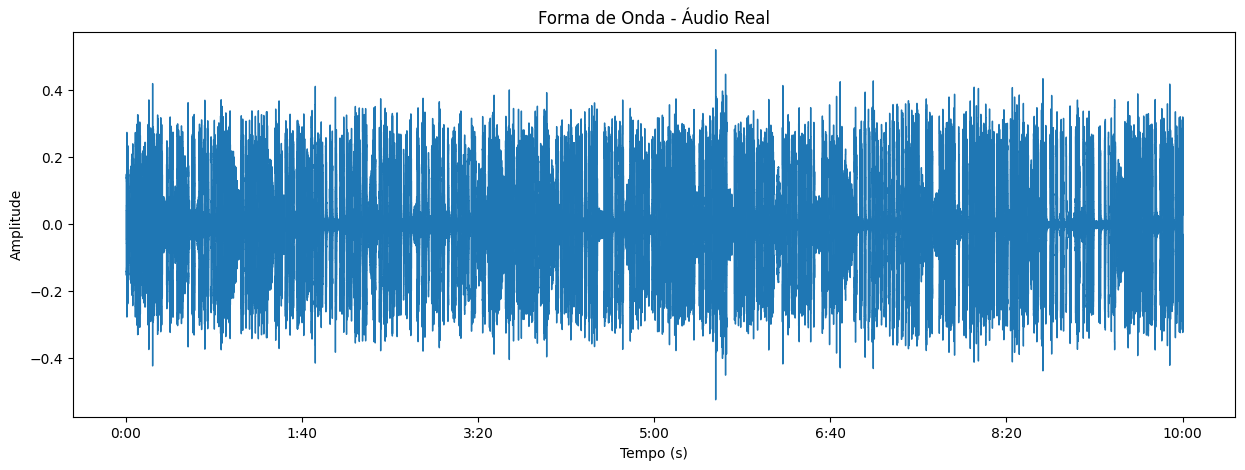

In [ ]:
showAudio(real_audio_dir + "/biden-original.wav")

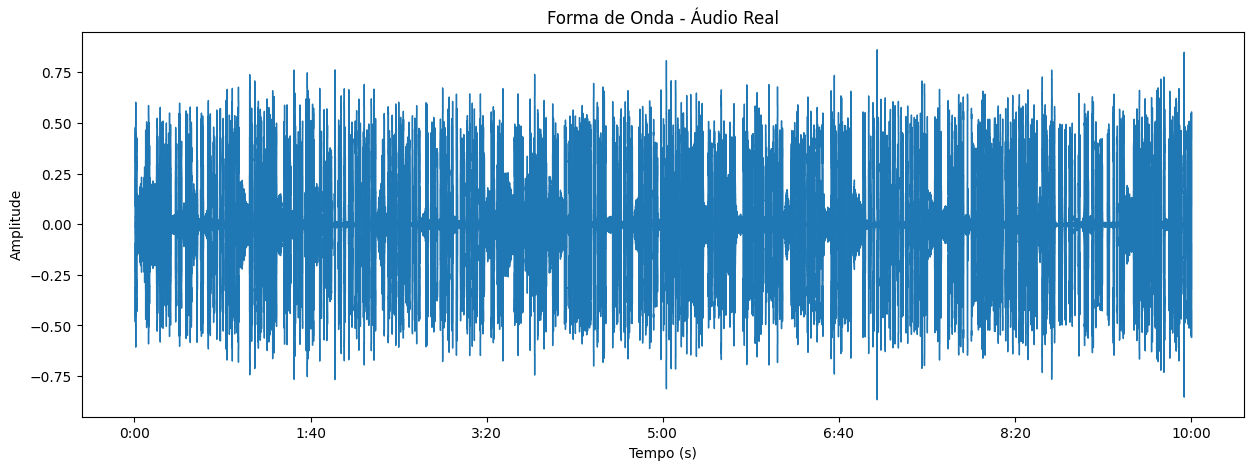

In [ ]:
showAudio(fake_audio_dir + "/biden-to-taylor.wav")

A análise visual das formas de onda sugere que o áudio "biden-to-taylor.wav" apresenta padrões irregulares na amplitude, indicando características associadas a deepfakes. Essa diferença pode ser explorada ainda mais por meio de técnicas de processamento de áudio e extração de características para desenvolver um modelo de classificação robusto capaz de distinguir entre áudios reais e deepfakes. O desafio reside em identificar padrões sutis que podem não ser visíveis a olho nu, mas que podem ser capturados por algoritmos de aprendizado de máquina.

Vamos analisar agora os espectogramas. Os espectrogramas são representações visuais da intensidade das frequências em relação ao tempo. Eles podem revelar padrões de frequência ao longo do tempo.

### Short-Time Fourier Transform (STFT)

A Transformada de Fourier de Curto Prazo (STFT) é uma técnica utilizada para analisar a frequência de um sinal em relação ao tempo. Em vez de calcular a transformada de Fourier de um sinal completo, a STFT divide o sinal em pequenos segmentos temporais e calcula a transformada de Fourier para cada segmento. Isso é essencial para analisar sinais não estacionários, ou seja, sinais cujas características mudam ao longo do tempo.

A biblioteca librosa oferece uma função conveniente, `librosa.stft`, para calcular a STFT de um sinal de áudio. Essa função aceita diversos parâmetros, incluindo o sinal de áudio, o tamanho da janela de Fourier (`n_fft`), o tamanho do salto entre segmentos consecutivos (`hop_length`), e o tamanho da janela de cada segmento (`win_length`).

A saída da função é uma matriz complexa que representa a STFT do sinal de áudio. Essa matriz pode ser utilizada para extrair informações espectrais ao longo do tempo.

Para uma melhor compreensão visual, a função `librosa.display.specshow` pode ser empregada para exibir o espectrograma associado à STFT, revelando padrões de frequência e variações temporais no sinal de áudio.


In [ ]:
def displaySpectogram(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    D = librosa.stft(y, n_fft=2048, hop_length=512, win_length=2048, window='hann')
    DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma')
    plt.tight_layout()
    plt.show()

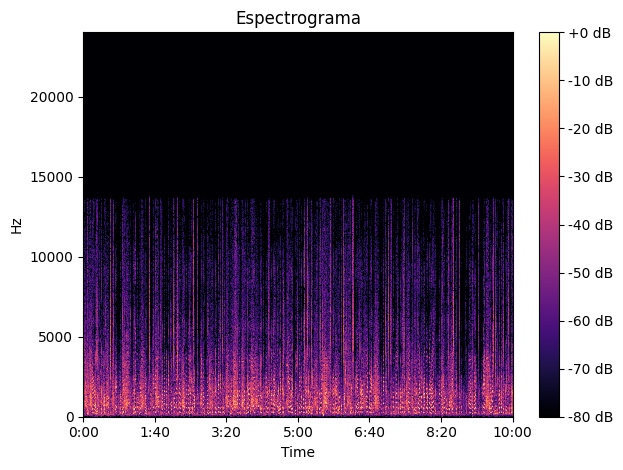

In [ ]:
displaySpectogram(real_audio_dir + "/biden-original.wav")

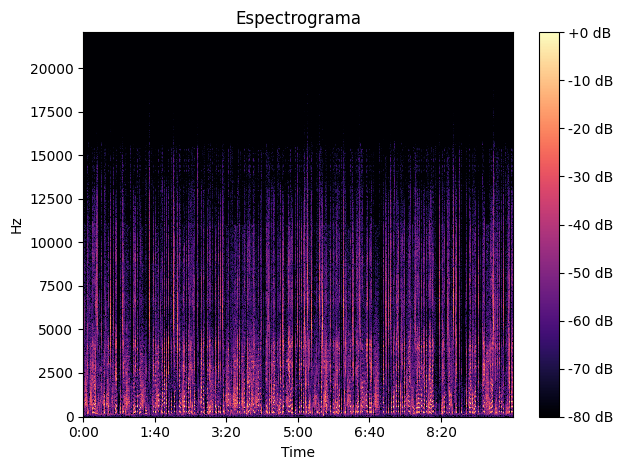

In [ ]:
displaySpectogram(fake_audio_dir + "/biden-to-taylor.wav")

A análise dos espectrogramas destaca diferenças marcantes entre os áudios "biden-original.wav" e "biden-to-taylor.wav". Enquanto o áudio real exibe padrões suaves e consistentes de frequência, o deepfake apresenta oscilações mais pronunciadas e variações irregulares.

# EXTRAÇÃO DE CARACTERÍSTICAS

Nesta etapa, realizamos a extração de características dos áudios para utilizá-las como entradas em nosso modelo de classificação. Utilizamos diversas técnicas para extrair informações relevantes dos sinais de áudio.

## Características que serão extraídas

### Chromagram

O *Chromagram* é uma representação do espectro de áudio no domínio da frequência tonal, calculado a partir da Transformada de Fourier de Tempo Curto (Short-Time Fourier Transform - STFT). Ele fornece informações sobre a distribuição da energia em diferentes faixas de tons musicais, sendo útil para identificar padrões tonais e melódicos nas gravações de áudio.

<center>$SG(m, k) = |X(m, k)|$</center>

### Spectral Centroid (SC)

O *Spectral Centroid* é a localização do centro de massa no espectro de áudio. Ele fornece uma medida da "brilhância" ou "tonalidade" do som, indicando a frequência média ponderada das amplitudes no sinal. Valores mais altos de *Spectral Centroid* geralmente indicam sons mais agudos, enquanto valores mais baixos indicam sons mais graves.

<center>$SC(m) = \frac{\sum_{k} [k \cdot SG(m, k)]}{\sum_{k} [SG(m, k)]}$</center>

### Spectral Bandwidth (SB)

A *Spectral Bandwidth* é a largura do espectro de frequência. Ela representa a dispersão das frequências no espectro de áudio e fornece informações sobre a "cor" ou "timbre" do som. A *Spectral Bandwidth* é calculada como a diferença entre as frequências ao redor do *Spectral Centroid*.

<center>$SB(m) = \sqrt{\frac{\sum_{k} [(k-SC(m))^2 \cdot SG(m, k)]}{\sum_{k} [SG(m, k)]}}$</center>

### Spectral Rolloff (SR)

O *Spectral Rolloff* é a frequência abaixo da qual uma porcentagem específica da energia total do espectro está contida. Ele fornece uma medida da inclinação do espectro de áudio e é útil para caracterizar a "brilhância" ou "agudeza" do som.
(SR é calculado via a frequência abaixo de 85% da energia espectral total)


### Zero Crossing Rate (ZCR)

A *Zero Crossing Rate* é a taxa na qual o sinal de áudio muda de sinal, ou seja, cruza o eixo x = 0 e muda de positivo para negativo ou vice-versa. Ela fornece informações sobre a frequência de variação do sinal de áudio e é útil para caracterizar a "textura" ou "aspereza" do som.

<center>$ZCR(m) = \frac{1}{2N} \sum_{n=1}^{N-1} [|sgn(x[n]) - sgn(x[n-1])|]$</center>


### Root Mean Square (RMS)

O *Root Mean Square* é uma medida da amplitude média do sinal de áudio. Ele fornece uma medida da "energia" ou "intensidade" do som, sendo útil para caracterizar a "loudness" ou "volume" do áudio.

<center>$RMS(m) = \sqrt{\frac{1}{N} \sum_{n=0}^{N-1} [(x[n])^2]}$</center>

### Mel-Frequency Cepstral Coefficients (MFCCs)

Os *Mel-Frequency Cepstral Coefficients* (MFCCs) são coeficientes cepstrais de frequência mel que representam as características mais significativas do espectro de áudio. Eles são calculados aplicando uma janela triangular ao espectro de potência, seguido por uma Transformada Cosseno Discreta (Discrete Cosine Transform - DCT). Os MFCCs capturam informações sobre a forma e a distribuição do espectro de áudio, sendo amplamente utilizados em aplicações de reconhecimento de voz e música.

## Funções de Extração de Características

In [ ]:
def extract_mfcc(audio_segment, sample_rate):
    features = librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=20)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_chroma_stft(audio_segment, sample_rate):
    features = librosa.feature.chroma_stft(y=audio_segment, sr=sample_rate)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_rms(audio_segment):
    features = librosa.feature.rms(y=audio_segment)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_spectral_centroid(audio_segment, sample_rate):
    features = librosa.feature.spectral_centroid(y=audio_segment, sr=sample_rate)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_spectral_bandwidth(audio_segment, sample_rate):
    features = librosa.feature.spectral_bandwidth(y=audio_segment, sr=sample_rate)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_spectral_rolloff(audio_segment, sample_rate):
    features = librosa.feature.spectral_rolloff(y=audio_segment, sr=sample_rate)
    avg_features = np.mean(features, axis=1)
    return avg_features

def extract_zero_crossing_rate(audio_segment):
    features = librosa.feature.zero_crossing_rate(y=audio_segment)
    avg_features = np.mean(features, axis=1)
    return avg_features

## Processamento dos Áudios

In [ ]:
def process_audio(label, audio_file, segment_duration=20):
    audio, sample_rate = librosa.load(audio_file, sr=None)
    num_segments = int(len(audio) / (sample_rate * segment_duration))

    features_list = []

    for i in range(num_segments):
        start = i * sample_rate * segment_duration
        end = (i + 1) * sample_rate * segment_duration
        segment = audio[start:end]
        features_chroma = extract_chroma_stft(segment, sample_rate)
        features_rms = extract_rms(segment)
        features_spectral_centroid = extract_spectral_centroid(segment, sample_rate)
        features_spectral_bandwidth = extract_spectral_bandwidth(segment, sample_rate)
        features_spectral_rolloff = extract_spectral_rolloff(segment, sample_rate)
        features_zero_crossing_rate = extract_zero_crossing_rate(segment)
        features_mfcc = extract_mfcc(segment, sample_rate)

        # Arredondar os valores para até a 6ª casa decimal
        features_chroma = np.round(features_chroma, 6)
        features_rms = np.round(features_rms, 6)
        features_spectral_centroid = np.round(features_spectral_centroid, 6)
        features_spectral_bandwidth = np.round(features_spectral_bandwidth, 6)
        features_spectral_rolloff = np.round(features_spectral_rolloff, 6)
        features_zero_crossing_rate = np.round(features_zero_crossing_rate, 6)
        features_mfcc = np.round(features_mfcc, 6)

        features_list.append(np.concatenate((features_chroma, features_rms, features_spectral_centroid, features_spectral_bandwidth, features_spectral_rolloff, features_zero_crossing_rate, features_mfcc)))

    feature_names = [f'chroma_{i}' for i in range(features_chroma.shape[0])] + ['rms', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate'] + [f'mfcc_{i}' for i in range(features_mfcc.shape[0])]

    df = pd.DataFrame(features_list, columns=feature_names)
    df['LABEL'] = label
    return df


In [ ]:
def saveAudioToCSV(file_name, data_df, label):
  file_name_2, _ = os.path.splitext(os.path.basename(file_name))

  new_file_name = file_name_2 + '.csv'

  csv_filename = "/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/" + label + os.path.basename(new_file_name)
  data_df.to_csv(csv_filename, index=False)

  print(f"Arquivo CSV salvo em: {csv_filename}")

In [ ]:
# arquivos_real = listar_arquivos(real_audio_dir)

# audio_features = []

# for filename in arquivos_real:
#     if filename.endswith(".wav"):
#         features_df = process_audio("REAL", filename)
#         saveAudioToCSV(filename, features_df, "REAL/")
#         audio_features.append(features_df.values.tolist())

Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL/biden-original.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL/linus-original.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL/margot-original.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL/musk-original.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL/obama-original.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL/ryan-original.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL/taylor-original.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/REAL/trump-original.csv


In [ ]:
# arquivos_fake = listar_arquivos(fake_audio_dir)

# oradores = ["biden", "obama", "musk", "taylor", "margot", "trump", "ryan", "linus"]

# for filename in arquivos_fake:
#     if filename.endswith(".wav"):
#         features_df = process_audio("FAKE", filename)
#         saveAudioToCSV(filename, features_df, "FAKE/")

Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/Obama-to-Biden.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/Obama-to-Trump.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-Obama.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-Trump.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-linus.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-margot.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-musk.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-ryan.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-taylor.csv
Arquivo CSV salvo em: /content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/linus-to-biden.csv
Arquivo CSV salvo em: /content

In [ ]:
oradores = ["biden", "obama", "musk", "taylor", "margot", "trump", "ryan", "linus"]

audios_escolhidos = {}

arquivos_fake_escolhidos = []

for orador in oradores:
    audios_orador = [arquivo for arquivo in csv_fakes if os.path.basename(arquivo).lower().startswith(orador)]
    audios_escolhidos[orador] = random.sample(audios_orador, 2)
    arquivos_fake_escolhidos += audios_escolhidos[orador]

for orador, audios in audios_escolhidos.items():
    print(f"Áudios escolhidos para {orador}:")
    for audio in audios:
        print(audio)

Áudios escolhidos para biden:
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-Obama.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-margot.csv
Áudios escolhidos para obama:
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/obama-to-margot.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/obama-to-musk.csv
Áudios escolhidos para musk:
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/musk-to-biden.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/musk-to-linus.csv
Áudios escolhidos para taylor:
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/taylor-to-linus.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/taylor-to-ryan.csv
Áudios escolhidos para margot:
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/margot-to-biden.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/margot-to-ryan.csv
Áudios escolhidos para trump:
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/trump-to-Oba

In [ ]:
oradores = ["biden", "obama", "musk", "taylor", "margot", "trump", "ryan", "linus"]

audios_escolhidos_2 = {}

arquivos_fake_escolhidos_2 = []

for orador in oradores:
    audios_orador = [arquivo for arquivo in csv_fakes if os.path.basename(arquivo).lower().startswith(orador) and arquivo not in audios_escolhidos[orador]]
    audios_escolhidos_2[orador] = random.sample(audios_orador, 4)
    arquivos_fake_escolhidos_2 += audios_escolhidos_2[orador]

for orador, audios in audios_escolhidos_2.items():
    print(f"Áudios escolhidos para {orador}:")
    for audio in audios:
        print(audio)

Áudios escolhidos para biden:
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-Trump.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-ryan.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-taylor.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/biden-to-linus.csv
Áudios escolhidos para obama:
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/Obama-to-Trump.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/Obama-to-Biden.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/obama-to-ryan.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/obama-to-linus.csv
Áudios escolhidos para musk:
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/musk-to-margot.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/musk-to-trump.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/musk-to-obama.csv
/content/drive/MyDrive/Sinais e Sistemas/Dados/CSV/FAKE/musk-to-ryan.csv
Áudios escolhido

In [ ]:
lista_dfs = []

for file_path in csv_reais + arquivos_fake_escolhidos + csv_reais:
    df_atual = pd.read_csv(file_path)
    lista_dfs.append(df_atual)

df_final = pd.concat(lista_dfs, ignore_index=True)

Aqui estamos concatenando os arquivos CSV salvos com as features de 24 audios, dois falsos selecionados para cada real, mas os dados reais são concatenados duas vezes, ou seja, os dados desses estão duplicados para balancear o dataset que iremos usar no treinamento


# BREVE EXPLORAÇÃO DOS DADOS

Nesta seção, realizamos uma breve análise inicial do conjunto de dados para obter insights valiosos sobre as características que coletamos.


In [ ]:
MD = df_final
MD.head()

,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,LABEL
0,0.306360,0.288492,0.361115,0.387263,0.433125,0.472029,0.470071,0.449808,0.381254,0.355118,...,-4.199198,-0.377555,-7.018171,-3.597043,-3.295263,-12.249346,-7.185244,-4.255551,-4.199633,REAL
1,0.403398,0.418587,0.361515,0.343138,0.319315,0.318012,0.347854,0.391745,0.384654,0.332034,...,-4.531120,-2.116330,-5.304652,-2.462757,-2.145301,-7.811224,-5.348325,-4.349914,-4.952616,REAL
2,0.359867,0.461899,0.546189,0.446068,0.264234,0.227414,0.287380,0.301809,0.353888,0.397733,...,-6.404880,-2.433353,-6.858251,-2.437085,-0.227266,-5.160735,-5.304330,-5.372996,-6.080935,REAL
3,0.420853,0.396122,0.381749,0.315881,0.257411,0.247832,0.276974,0.324700,0.425956,0.321608,...,-9.628351,-0.092169,-5.221566,-4.402748,-0.361533,-6.313690,-5.721716,-3.640514,-3.817391,REAL
4,0.383271,0.385470,0.391723,0.417270,0.397775,0.336911,0.334613,0.332120,0.355973,0.323622,...,-7.551392,-0.928683,-5.508522,-2.517222,-2.021242,-8.306838,-6.239684,-4.918522,-4.775888,REAL


## Descrição Estatística para Dados REAIS e FAKES

In [ ]:
grouped_data = MD.groupby('LABEL')

grouped_data.get_group('REAL').describe()

,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,...,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,0.419098,0.413160,0.406453,0.403603,0.397633,0.401651,0.409340,0.421128,0.434050,0.428638,...,-3.452428,-5.008314,-2.183210,-2.478346,-2.725417,-2.803250,-2.963639,-4.525737,-2.102111,-4.019907
std,0.061782,0.053000,0.056812,0.078633,0.086246,0.076911,0.060640,0.055578,0.056862,0.063695,...,5.620497,5.876250,3.137934,3.505423,4.144681,4.512034,3.989516,3.960233,3.696925,5.212085
min,0.287153,0.283436,0.258978,0.219760,0.216244,0.227414,0.276974,0.230277,0.246673,0.278525,...,-17.310303,-19.619354,-8.878820,-10.126081,-12.455880,-13.774290,-12.249346,-14.723181,-14.737139,-15.706419
25%,0.371606,0.380660,0.361515,0.339296,0.319315,0.338871,0.365045,0.383803,0.395519,0.378821,...,-6.992114,-7.489316,-4.129058,-4.844256,-5.013104,-3.683417,-6.488280,-6.506629,-4.854556,-5.789594
50%,0.413991,0.413297,0.410606,0.417490,0.401886,0.395581,0.401532,0.423278,0.434950,0.424667,...,-2.259493,-4.978516,-2.037210,-2.423945,-3.044663,-1.446748,-3.154600,-4.041308,-2.687385,-3.467384
75%,0.462520,0.451048,0.445151,0.471722,0.471766,0.470336,0.455383,0.461167,0.475627,0.480238,...,0.921575,-2.438148,-0.164368,0.118665,0.613029,0.429895,0.312835,-1.864726,1.254423,-0.374640
max,0.565600,0.538682,0.546189,0.544156,0.574414,0.605456,0.553439,0.554845,0.570875,0.563623,...,7.296120,6.926667,4.428043,4.775608,4.444420,4.715726,5.185005,2.980438,4.879610,4.370759


In [ ]:
grouped_data.get_group('FAKE').describe()

,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,...,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000
mean,0.457290,0.446475,0.435543,0.427120,0.406464,0.405612,0.404972,0.421178,0.440264,0.451544,...,-1.788060,-2.022960,-2.849299,-3.120745,-2.685149,-1.771794,-4.754962,-2.500814,-3.343020,-4.644591
std,0.059587,0.064169,0.063122,0.063951,0.072311,0.067760,0.058822,0.057569,0.068440,0.074539,...,3.639502,3.570442,4.673227,3.008753,3.088743,4.502813,2.969941,3.236312,4.608262,4.087418
min,0.299205,0.278743,0.253638,0.235839,0.206142,0.200249,0.231276,0.234884,0.263330,0.262468,...,-9.925982,-11.539681,-12.125230,-8.302676,-12.529886,-12.298382,-11.149334,-8.209737,-13.990278,-14.678595
25%,0.420549,0.407435,0.393049,0.389090,0.362515,0.367112,0.369300,0.383977,0.393326,0.400180,...,-4.285069,-4.351074,-7.378736,-5.182272,-4.326919,-3.839040,-7.226104,-4.546744,-5.610343,-6.796409
50%,0.466837,0.456903,0.441630,0.435486,0.420738,0.416162,0.408982,0.423396,0.439545,0.456013,...,-2.012849,-2.115029,-2.466091,-3.815869,-2.135175,-1.125320,-4.811414,-3.002924,-2.230950,-3.527593
75%,0.497670,0.495477,0.482437,0.471388,0.456377,0.455187,0.448664,0.456214,0.486656,0.505320,...,0.388816,-0.091264,0.766570,-1.680858,-0.556892,1.044564,-2.570264,-1.258442,-0.266957,-1.638973
max,0.587117,0.576004,0.583900,0.595664,0.587495,0.623644,0.548178,0.623918,0.629724,0.612556,...,10.268966,7.638876,7.755192,7.226996,4.400895,7.942324,3.450314,8.251786,4.309679,2.475161


Aqui, agrupamos os dados com base na coluna 'LABEL' e calculamos a descrição estatística para o grupo de dados rotulado como 'REAL' e 'FAKE'. Isso inclui estatísticas como média, desvio padrão, quartis, etc., fornecendo uma visão detalhada das características dos áudios reais. Com isso, podemos comparar as características estatísticas entre áudios reais e deepfakes.

In [ ]:
MD['LABEL'].value_counts()

FAKE    185
REAL    185
Name: LABEL, dtype: int64

# TREINAMENTO DO MODELO


No decorrer de nossa análise, utilizando métricas como acurácia e precisão para avaliar o desempenho, identificamos que o modelo K-Nearest Neighbors (KNN) com apenas um vizinho mais próximo se destacou como o mais eficaz. Curiosamente, apesar de sua simplicidade comparativa em relação a abordagens mais complexas, o KNN demonstrou ser excepcionalmente competente, superando outros modelos testados. Este resultado é particularmente notável considerando que o KNN, devido à sua natureza fundamentalmente simples, muitas vezes não é esperado para superar modelos mais sofisticados. Nosso estudo avançou com métodos de teste que consideramos serem os mais robustos, e nesse contexto, a superioridade do KNN foi ainda mais evidente, sublinhando que, mesmo sendo um modelo simples, pode alcançar resultados surpreendentemente bons.

In [ ]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):

    cm = confusion_matrix(y_test, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão, sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadeira')
    plt.xlabel('Etiqueta prevista')

Acurácia: 0.8986486486486487

Relatório de Classificação:
               precision    recall  f1-score   support

        FAKE       0.97      0.84      0.90        79
        REAL       0.84      0.97      0.90        69

    accuracy                           0.90       148
   macro avg       0.90      0.90      0.90       148
weighted avg       0.91      0.90      0.90       148

Matriz de confusão normalizada


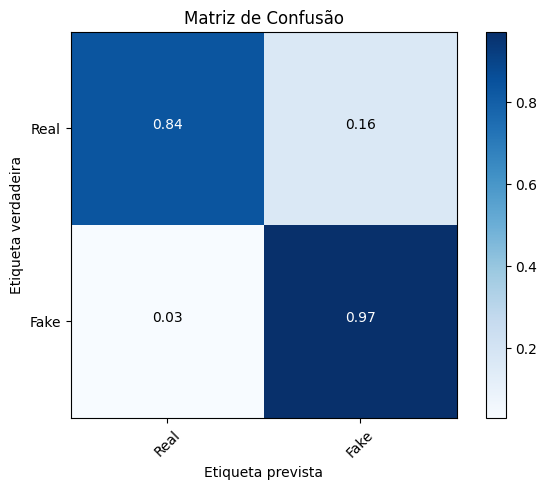

In [ ]:
# Divisão dos Dados
X = MD.drop('LABEL', axis=1)
y = MD['LABEL']

# Normalização dos Dados
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Divisão em Conjuntos de Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento do Modelo
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(X_train, y_train)

# Avaliação do Modelo
y_pred = knn_classifier.predict(X_test)

# Exibição de Métricas
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, ["Real", "Fake"])


Os resultados do treinamento do modelo KNN para a detecção de deepfakes em áudios são promissores. Com uma acurácia global de aproximadamente 89.9%, o modelo exibe boa precisão e recall para ambas as classes ("FAKE" e "REAL"). A análise detalhada revela uma precisão de 97% na detecção de deepfakes, indicando que, quando classifica um áudio como falso, o modelo está correto em 97% das vezes. O recall de 97% para áudios reais sugere que o modelo identifica corretamente a maioria dos áudios autênticos. A matriz de confusão mostra um número limitado de falsos positivos e falsos negativos.

Para assegurar a imparcialidade e a precisão dos resultados, selecionamos uma série de áudios gerados por deep fake que não foram incorporados ao conjunto de treinamento do modelo para incluí-los no dataset de testes em uma análise posterior.

A inclusão de áudios deep fake não vistos anteriormente pelo modelo em nosso dataset de testes serviu para simular um cenário mais realista, no qual o modelo seria confrontado com novas amostras de deep fakes potencialmente desconhecidas após a sua implantação. Essa estratégia visa evitar o overfitting, uma condição onde o modelo performa excepcionalmente bem nos dados de treinamento devido à memorização, mas falha ao generalizar para novos dados.

Além disso, ao testar o modelo com áudios não utilizados no treinamento, pudemos avaliar sua capacidade de generalização. Isso é, sua habilidade de aplicar o conhecimento adquirido durante o treinamento para identificar com precisão deep fakes em amostras que nunca havia encontrado, refletindo assim o desempenho real do modelo em um ambiente operacional.

In [ ]:
test_dfs = []

for file_path in csv_reais + arquivos_fake_escolhidos_2:
    df_atual = pd.read_csv(file_path)
    test_dfs.append(df_atual)

new_test = pd.concat(lista_dfs, ignore_index=True)

Acurácia nos novos dados: 0.9797297297297297

Relatório de Classificação:
               precision    recall  f1-score   support

        FAKE       0.99      0.96      0.98       370
        REAL       0.97      0.99      0.98       370

    accuracy                           0.98       740
   macro avg       0.98      0.98      0.98       740
weighted avg       0.98      0.98      0.98       740

Matriz de confusão, sem normalização


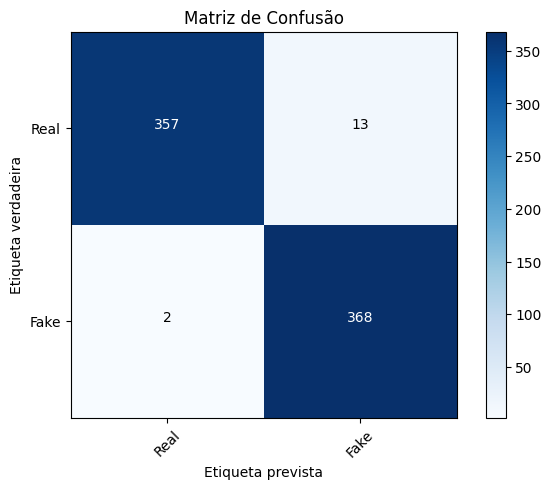

In [ ]:
# Normalizar os dados de teste
X_fake_test = new_test.drop('LABEL', axis=1)
y_fake_test = new_test['LABEL']

X_fake_test_normalized = scaler.fit_transform(X_fake_test)

# Prever rótulos usando o modelo k-NN
predictions_fake_test = knn_classifier.predict(X_fake_test)

# Avaliar a acurácia
accuracy_fake_test = accuracy_score(y_fake_test, predictions_fake_test)
print(f'Acurácia nos novos dados: {accuracy_fake_test}')
print("\nRelatório de Classificação:\n", classification_report(y_fake_test, predictions_fake_test))

plot_confusion_matrix(y_fake_test, predictions_fake_test, ["Real", "Fake"])

A validação do preditor utilizando uma nova amostra de áudios, composta por dados reais e uma seleção adicional de áudios deepfake, revela uma acurácia notável de aproximadamente 97.97%. O modelo KNN demonstra consistência ao classificar tanto áudios genuínos quanto deepfakes, apresentando uma precisão e recall excepcionais para ambas as classes. A análise detalhada destaca a eficácia do modelo, com uma precisão de 99% na detecção de deepfakes, indicando sua capacidade de identificar corretamente a grande maioria dos áudios sintéticos. O recall de 96% para áudios reais sugere uma taxa de detecção eficiente para áudios autênticos. A matriz de confusão destaca apenas alguns casos de falsos positivos e falsos negativos. Em resumo, o preditor KNN demonstra um desempenho robusto na detecção de deepfakes em uma variedade de áudios, reforçando sua utilidade e eficácia.

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def train_audio_model_from_df(dataframe):
    """
    Treina um modelo para classificar áudios em 'fake' ou 'real' baseado em um DataFrame.
    """
    # Separar features e labels
    X = dataframe.iloc[:, :-1].values  # Todas as colunas exceto a última
    y = dataframe.iloc[:, -1].values  # A última coluna contém as labels

    # Codificar labels 'REAL' e 'FAKE' numericamente
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)  # Converter para one-hot encoding

    # Dividir os dados em conjuntos de treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

    # Reformatar os dados para o formato esperado pela CNN 1D
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Construir o modelo
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(y_categorical.shape[1], activation='sigmoid')
    ])

    # Compilar o modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

    return model, history

# Supondo que 'df' seja o seu DataFrame contendo as features e a coluna 'label'

model, history = train_audio_model_from_df(MD.sample(frac=1).reset_index(drop=False))

Epoch 1/100
19/19 [==============================] - 4s 79ms/step - loss: 46.9303 - accuracy: 0.5051 - val_loss: 23.7706 - val_accuracy: 0.5135
Epoch 2/100
19/19 [==============================] - 0s 23ms/step - loss: 16.3003 - accuracy: 0.5338 - val_loss: 14.2607 - val_accuracy: 0.5135
Epoch 3/100
19/19 [==============================] - 0s 21ms/step - loss: 9.7426 - accuracy: 0.6588 - val_loss: 5.1998 - val_accuracy: 0.7297
Epoch 4/100
19/19 [==============================] - 0s 15ms/step - loss: 3.5892 - accuracy: 0.7416 - val_loss: 3.2490 - val_accuracy: 0.7432
Epoch 5/100
19/19 [==============================] - 0s 15ms/step - loss: 3.3213 - accuracy: 0.6959 - val_loss: 7.7793 - val_accuracy: 0.5743
Epoch 6/100
19/19 [==============================] - 0s 18ms/step - loss: 3.0882 - accuracy: 0.7280 - val_loss: 1.3918 - val_accuracy: 0.7635
Epoch 7/100
19/19 [==============================] - 0s 21ms/step - loss: 1.4690 - accuracy: 0.8007 - val_loss: 8.3780 - val_accuracy: 0.5135
Ep

24/24 [==============================] - 0s 5ms/step
Acurácia: 0.9959
Precisão: 0.9959
Matriz de confusão, sem normalização


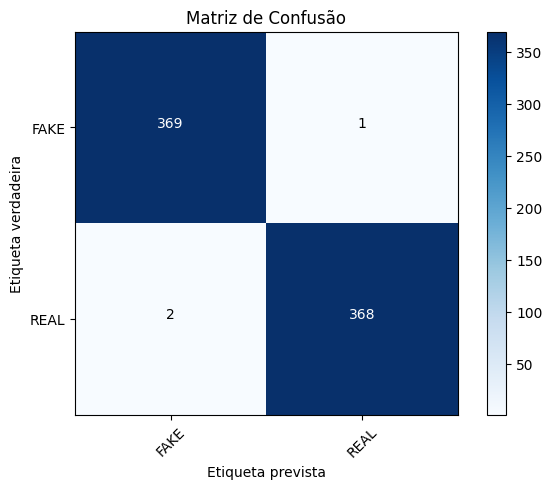

In [ ]:
def evaluate_model(model, test_dataframe):
    """
    Avalia o modelo treinado em um dataframe de teste, calculando e imprimindo a acurácia e precisão.
    """
    # Separar features e labels
    X_test = test_dataframe.iloc[:, :-1].values  # Todas as colunas exceto a última
    y_test = test_dataframe.iloc[:, -1].values  # A última coluna contém as labels

    # Codificar labels 'REAL' e 'FAKE' numericamente
    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)
    y_test_categorical = to_categorical(y_test_encoded)  # Converter para one-hot encoding

    # Reformatar os dados para o formato esperado pela CNN 1D
    X_test = X_test[..., np.newaxis]

    # Fazer previsões
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test_categorical, axis=1)

    # Calcular acurácia e precisão
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='macro')

    print(f'Acurácia: {accuracy:.4f}')
    print(f'Precisão: {precision:.4f}')

    plot_confusion_matrix(y_test_encoded, predicted_classes, classes=["FAKE", "REAL"])

    return accuracy, precision

accuracy, precision = evaluate_model(model, new_test.sample(frac=1).reset_index(drop=False))
